[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/advection_diffusion_2d/advection-diffusion-2d.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PyMPDATA.git/main?urlpath=lab/tree/examples/PyMPDATA_examples/advection_diffusion_2d/advection-diffusion-2d.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PyMPDATA/blob/main/examples/PyMPDATA_examples/advection_diffusion_2d/advection-diffusion-2d.ipynb)

In [1]:
from open_atmos_jupyter_utils import show_plot

In [2]:
import os
import numpy as np
import imageio
from IPython.display import display
from ipywidgets import FloatProgress
import matplotlib.pyplot as plt
from PyMPDATA import Solver, ScalarField, VectorField, Stepper, Options
from PyMPDATA.boundary_conditions import Periodic

In [3]:
mu = 0.0005 # diffusion coefficient
dt = 0.025
tmax = 5.0
nt = int(tmax / dt)

nx = 32
ny = 32
ux  = 0.25
uy = 0.25

omega = np.pi

min_x, min_y = -1, -1
max_x, max_y = 1, 1
dx = (max_x - min_x) / nx
dy = (max_y - min_y) / ny
Cx = ux * dt / dx
Cy = uy * dt / dy

In [4]:
opt = Options(n_iters=3, non_zero_mu_coeff=True)
boundary_conditions = (Periodic(), Periodic())

In [5]:
def analytic_solution(x, y, t):
    return np.sin(omega*(x-ux*t+y-uy*t))*np.exp(-2*mu*t*omega**2) + 1

In [6]:
def z(t):
    return np.array(
    [
        analytic_solution(x, y, t=t) for x in np.linspace(min_x, max_x, nx)
        for y in np.linspace(min_y, max_y, ny)
    ],
    dtype=float
).reshape((nx, ny))

advectee = ScalarField(data=z(t=0), halo=opt.n_halo, boundary_conditions=boundary_conditions)

In [7]:
field_x = np.full((nx+1, ny), Cx, dtype=opt.dtype)
field_y = np.full((nx, ny+1), Cy, dtype=opt.dtype)

advector = VectorField(
    data=(field_x, field_y),
    halo=opt.n_halo,
    boundary_conditions=(boundary_conditions[0], Periodic())
)

In [8]:
stepper = Stepper(options=opt, n_dims=2)
solver = Solver(stepper=stepper, advector=advector, advectee=advectee)

/home/konrad/anaconda3/envs/mpdata/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [9]:
vmin = np.min(solver.advectee.get())
vmax = np.max(solver.advectee.get())

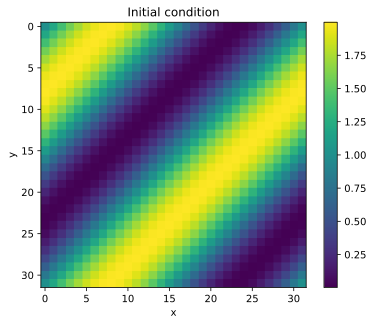

In [10]:
plt.imshow(solver.advectee.get().copy(), cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Initial condition')
show_plot("fig_1")

In [11]:
progbar = FloatProgress(value=0, min=0, max=1)
display(progbar)

states_history = [solver.advectee.get().copy()]
for i in range(nt//10):
    solver.advance(n_steps=10, mu_coeff=(mu, mu))
    states_history.append(solver.advectee.get().copy())
    progbar.value = (i + 1.) / (nt//10)

FloatProgress(value=0.0, max=1.0)

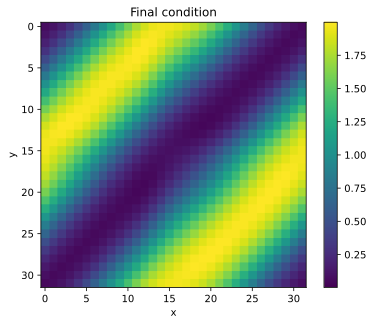

In [12]:
plt.imshow(solver.advectee.get().copy(), cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Final condition')
show_plot("fig_2")

In [13]:
assert np.allclose(solver.advectee.get(), z(t=nt*dt), atol=0.25)

In [14]:
os.makedirs("animation", exist_ok=True)
for i, state in enumerate(states_history):
    state = np.flipud(state)
    plt.imshow(state, cmap='viridis')
    plt.axis('off')
    plt.tight_layout()
    plt.colorbar()
    plt.savefig(f"animation/frame_{i:03d}.png")
    plt.close()

In [15]:
def merge_images_into_gif(image_folder, gif_name, duration=0.01):
    with imageio.get_writer(gif_name, mode='I', duration=duration) as writer:
        for filename in sorted(os.listdir(image_folder)):
            image = imageio.v3.imread(os.path.join(image_folder, filename))
            writer.append_data(image)

In [16]:
merge_images_into_gif("animation", "advection_diffusion.gif", duration=0.01)